In [2]:
import pandas as pd
pd.set_option('display.max_rows', 100)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['axes.facecolor'] = 'white'

from notebook_utils import *
from core_modules.data_processor import DataProcessor

# to compute holidays/workdays based on the country
import holidays

In [3]:
# read csv file
df = pd.read_csv('nawy_dataset.csv', low_memory=False, parse_dates=['lead_time'])

# drop redundant unnamed columns if exists (sometimes this problem is caused when opening file in excel first)
cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
df.drop(columns=cols_to_drop, inplace=True)

# parse timestamps in the lead_time column properly
df['lead_time'] = pd.to_datetime(df['lead_time'], errors='coerce')
df.dropna(subset=['lead_time'], inplace=True)
df['lead_time'] = df['lead_time'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

df.head()

,lead_id,customer_name,lead_mobile_network,message,lead_time,method_of_contact,ad_group,lead_source,campaign,location,low_qualified
0,22,Rajaa M.Mousa,Orange,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:21,generic form,none,google,dev_-_sodic,sodic october plaza,0
1,30,Sahar Shalaby,Vodafone,ad_id : 23843176891470664 \nform_id : 36774549...,2019-09-16 13:17:18,facebook,o west - fb_creme de la creme_ cairo/giza_27-60,facebook,orascom - lead generation,o west,0
2,42,Mohamed,Vodafone,message:,2022-05-07 02:03:54,generic form,gouna_-_properties,google,locations,el gouna for sale & resale,0
3,44,Maher Elnakib,Orange,ad_id : 23844249544660664 \nadset_id : 2384424...,2019-12-19 22:56:47,facebook,new release north edge general with north coas...,facebook,city edge - lead generation,north edge,0
4,48,pierre,Vodafone,message:,2022-01-27 05:56:23,top compounds form,none,google,dev_-_inertia_egypt,joulz,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91121 entries, 0 to 91128
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   lead_id              91121 non-null  int64 
 1   customer_name        91121 non-null  object
 2   lead_mobile_network  91121 non-null  object
 3   message              88846 non-null  object
 4   lead_time            91121 non-null  object
 5   method_of_contact    91121 non-null  object
 6   ad_group             91049 non-null  object
 7   lead_source          91121 non-null  object
 8   campaign             90341 non-null  object
 9   location             90972 non-null  object
 10  low_qualified        91121 non-null  object
dtypes: int64(1), object(10)
memory usage: 8.3+ MB


In [5]:
df['low_qualified'] = df['low_qualified'].astype('int64')
df['low_qualified'].value_counts()

0    75136
1    15985
Name: low_qualified, dtype: int64

## Objective

### Classify leads as high quality and low quality leads
### Target Column: low_qualified (0 -> high quality leads / 1 -> low quality lead)
### At this problem, we care the most about miss classifying high quality leads. Meaning we care the most about minimizing "False Positives". Therefore, our main performance metric is the "Recall" metric

In [50]:
# check for duplicate leads

unique_df = df.drop_duplicates(subset ="lead_id", keep='first')
print(f'unique leads: {len(unique_df)} - duplicate leads: {len(df)-len(unique_df)}')

unique leads: 72288 - duplicate leads: 18833


In [51]:
unique_df['low_qualified'].value_counts()

0    61238
1    11050
Name: low_qualified, dtype: int64

In [52]:
data_processor = DataProcessor(df=df)

## Exploration, Analysis and Wrangling
### Sequnece:
1. lead_time
2. lead_mobile_network
3. lead_souce
4. method_of_contact

### 1. Lead Time

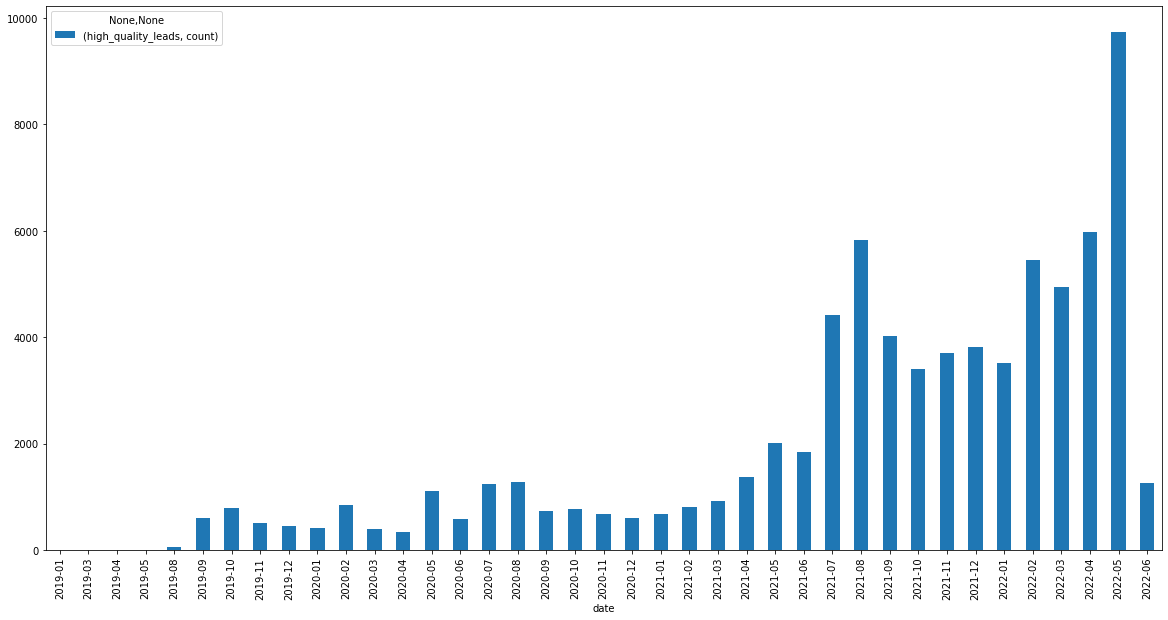

In [53]:
high_quality_leads_df = df[df['low_qualified'] == 0]

lead_time_split_df = pd.DataFrame({
    'date': pd.to_datetime(high_quality_leads_df['lead_time']).dt.date.apply(lambda x: x.strftime('%Y-%m')),
    'high_quality_leads': high_quality_leads_df['low_qualified'], 
})
monthly_quality_leads_df = lead_time_split_df.groupby(['date']).agg({'count'}).reset_index()
ax = monthly_quality_leads_df.plot(x='date', y=[('high_quality_leads', 'count')], kind='bar', figsize=(20,10))
ax.get_figure().savefig('figures/month-year-grouped.jpg')

### From the above grah we definetly see some trends regarding how much of qualified leads are generated per month, so the month value will most probably affect our classification.
### I would have plotted a similar graphs but grouped by years, but unfortunatley we don't have the ful 3 years (2019->2022) in data, so we would have a lot of months missing, therefore, inaccurate data.
### Also it would have been useful to detect leads' workdays/holidays using pypi's "holidays" package, but we don't know exactly where each lead is located since there a re a lot of international leads in th Gulf, Europe, US and Canada. It would be usefult to know where exactly each lead reside.

In [9]:
# separate the lead_time column to month and year columns

df['lead_time'] = pd.to_datetime(df['lead_time'])

df.insert(5, 'month', df['lead_time'].dt.month)
df.insert(6, 'year', df['lead_time'].dt.year)

### 2. Lead Mobile Network

In [10]:
unique_df = data_processor.get_unique_df()
unique_df['lead_mobile_network'].value_counts()

Vodafone    30793
Orange      14558
Etisalat    12923
Gulf         9642
Others       1770
US_Canda      950
Europe        911
WE            741
Name: lead_mobile_network, dtype: int64

In [11]:
mobile_network_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_mobile_network', list(unique_df['lead_mobile_network'].unique()))
mobile_network_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,Orange,12497,14558,0.858428
1,Vodafone,25867,30793,0.840029
2,Etisalat,10357,12923,0.801439
3,Gulf,8857,9642,0.918585
4,US_Canda,895,950,0.942105
5,Others,1330,1770,0.751412
6,Europe,857,911,0.940724
7,WE,578,741,0.780027


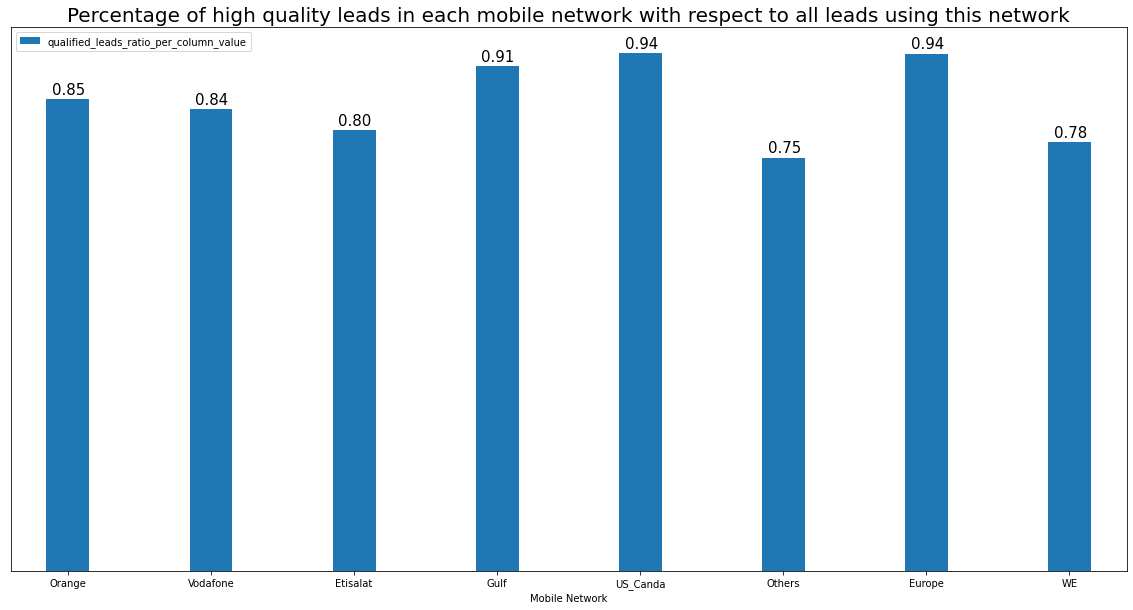

In [12]:
ax = mobile_network_analysis_df.plot(x='column unique values', y=['qualified_leads_ratio_per_column_value'], kind='bar', figsize=(20,10), width=0.3, rot=0)
ax.set_xlabel('Mobile Network')
ax.set_title('Percentage of high quality leads in each mobile network with respect to all leads using this network', fontsize='20')
ax.legend(loc='upper left')
ax.axes.get_yaxis().set_ticks([])
for p in ax.patches:
    ax.annotate(text=str(p.get_height())[:4], xy=(p.get_x() + 0.04, p.get_height() + 0.01), fontsize=15)
ax.get_figure().savefig(f'figures/mobile network high leads ratio to wrt total number of leads in netwrok.jpg')

### From the above dataframe and graph we notice the followwing:

- Gulf, US, Canada, Europe have the highest quality customers but the don't necessarily generate the most leads.
- Vodafone generates the most leads but and with a high quality leads
- WE and "Others" leads generate the lowest quality leads

### 3. Lead Source

In [13]:
print_column_value_counts(unique_df, 'lead_source')

facebook - 41114
google - 15266
website - 3452
phone - 2361
personal - 1643
organic search - 1295
hotline - 1058
google/landing page - 918
landing page - 870
app - 757
whatsapp - 701
unknown - 499
organic form - 442
vodafone - 436
sms - 305
client referral - 192
propertyfinder - 140
direct traffic - 118
intercom - 92
personal/rafea - 81
management referral - 64
personal/ghanima - 43
top component form - 41
mobile app - 37
google-landing pages - 31
bing.com - 27
cold call - 26
call center resale - 23
instagram messenger - 21
r.search.yahoo.com - 18
type form - 17
linkedin - 15
organic form direct - 10
instagram page referral - 10
search.yahoo.com - 9
form - 9
referral - 8
instagram comment - 8
managment referral - 7
fb messenger - 7
personal aly - 7
referral page - 7
egyptianstreets.com - 7
com.google.android.googlequicksearchbox - 5
instagram message - 4
newchat.ktree.org - 4
custom form - 3
website unkown - 3
callcenter - 3
whastapp - 3
resale form - 2
linkedin.com - 2
uk.search.yahoo

#### Obviously the lead_source column is so messy with a lot of typos and redundancy, so it is best to group similar values together if and only if we made sure they actually generate leads in the same quality range

In [14]:
# group ambigious/unknown sources together in one value

ambigious = ['Unknown', 'None', 'Localhost', 'Test', 'Unkown']
ambigious_combinations = []
for word in ambigious:
    ambigious_combinations.append(word)
    ambigious_combinations.append(f'({word})')
    ambigious_combinations.append(word.lower())
    ambigious_combinations.append(f'({word.lower()})')

df.loc[df['lead_source'].str.contains('|'.join(ambigious_combinations)), 'lead_source'] = 'unknown'

# fix/symple some redundant values due to typos or other reasons
df.loc[(df['lead_source'].str.contains('what')) | (df['lead_source'].str.contains('whast')), 'lead_source'] = 'whatsapp'
df.loc[df['lead_source'] == 'youtube.com', 'lead_source'] = 'youtube'
df.loc[df['lead_source'].str.contains('linkedin'), 'lead_source'] = 'linkedin'
df.loc[df['lead_source'].str.contains('telegram'), 'lead_source'] = 'telegram'

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

C:\Users\Orignal\AppData\Local\Temp/ipykernel_15968/2135163135.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df['lead_source'].str.contains('|'.join(ambigious_combinations)), 'lead_source'] = 'unknown'


#### Do the same for social media sources, personal sources (personal, personal/rafae, ...etc)

In [15]:
personal_sources = [source for source in df['lead_source'].unique() if ('personal' in source or 'referral' in source or 'client' in source)]
personal_sources_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', personal_sources)
personal_sources_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,client referral,190,192,0.989583
1,referral,8,8,1.000000
2,management referral,64,64,1.000000
3,omar bebars/referral,1,1,1.000000
4,personal,1609,1643,0.979306
5,personal/ghanima,41,43,0.953488
6,client/referral,1,1,1.000000
7,personal aly,7,7,1.000000
8,referral from nadine amr,1,1,1.000000
9,personal/referral,1,1,1.000000


In [16]:
df.loc[df['lead_source'].isin(personal_sources), 'lead_source'] = 'personal'

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

### Analyze and compare between social media platforms

In [17]:
instagram_sources = [source for source in df['lead_source'].unique() if 'instagram' in source]

instagram_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', instagram_sources)
instagram_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,instagram message,4,4,1.000000
1,instagram comment,7,8,0.875000
2,instagram messenger,16,21,0.761905
3,instagram,1,1,1.000000


In [18]:
facebook_sources = [source for source in df['lead_source'].unique() if 'facebook' in source or 'fb' in source]

faebook_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', facebook_sources)
faebook_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,facebook,34622,41114,0.842098
1,fb messenger,7,7,1.000000
2,fb comment,2,2,1.000000


In [19]:
whatsapp_sources = [source for source in df['lead_source'].unique() if 'whatsapp' in source]

whatsapp_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', whatsapp_sources)
whatsapp_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,whatsapp,669,706,0.947592


In [20]:
linkedin_sources = [source for source in df['lead_source'].unique() if 'linkedin' in source]

linkedin_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', linkedin_sources)
linkedin_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,linkedin,9,17,0.529412


In [21]:
telegram_sources = [source for source in df['lead_source'].unique() if 'telegram' in source]

telegram_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', telegram_sources)
telegram_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,telegram,1,1,1.0


#### From reviewing the above datafraes, apparently facebook has a major rol in generating leads, also other social media platform really poorly in  terms of absolute leads count generated

In [22]:
dfs = [faebook_analysis_df, instagram_analysis_df, whatsapp_analysis_df, telegram_analysis_df, linkedin_analysis_df]

messenger = []
for curr_df in dfs[:-1]:
    messenger_row = curr_df[curr_df['column unique values'].str.contains('messenger')]
    if not messenger_row.empty:
        messenger.append(messenger_row['qualified_leads_ratio_per_column_value'].iloc[0])
    else:
        messenger.append(curr_df['qualified_leads_ratio_per_column_value'].iloc[0])
messenger.append(0.0)

posts = [
    faebook_analysis_df[faebook_analysis_df['column unique values'] == 'facebook']['qualified_leads_ratio_per_column_value'].iloc[0],
    instagram_analysis_df[instagram_analysis_df['column unique values'] == 'instagram']['qualified_leads_ratio_per_column_value'].iloc[0],
    0.0,
    0.0,
    linkedin_analysis_df[linkedin_analysis_df['column unique values'] == 'linkedin']['qualified_leads_ratio_per_column_value'].iloc[0]
]

comments = [
    faebook_analysis_df[faebook_analysis_df['column unique values'].str.contains('comment')]['qualified_leads_ratio_per_column_value'].iloc[0],
    instagram_analysis_df[instagram_analysis_df['column unique values'].str.contains('comment')]['qualified_leads_ratio_per_column_value'].iloc[0],
    0.0,
    0.0,
    0.0
]

social_media_analysis = pd.DataFrame({
    'platform': ['facebook', 'instagram', 'whatsapp', 'telegram', 'linkedin'],
    'messenger': messenger,
    'posts/stories/ads': posts,
    'comments': comments,
})

social_media_analysis

,platform,messenger,posts/stories/ads,comments
0,facebook,1.000000,0.842098,1.000
1,instagram,0.761905,1.000000,0.875
2,whatsapp,0.947592,0.000000,0.000
3,telegram,1.000000,0.000000,0.000
4,linkedin,0.000000,0.529412,0.000


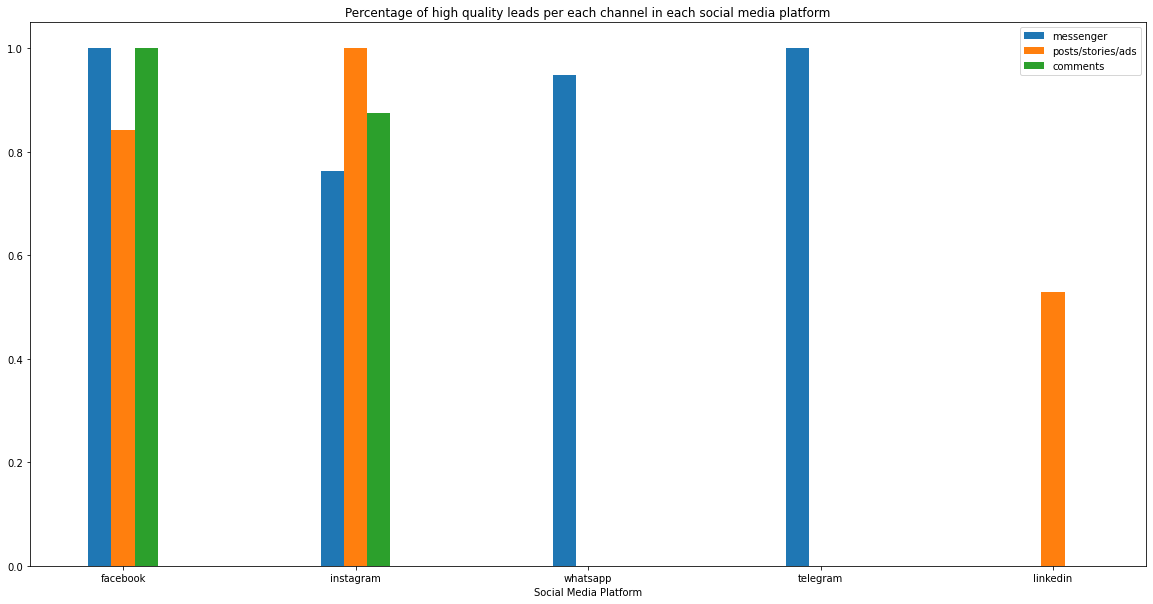

In [23]:
social_media_plot = social_media_analysis.plot(x='platform', y=['messenger', 'posts/stories/ads', 'comments'], kind='bar', rot=0, figsize=(20,10), width=0.3)
social_media_plot.set_xlabel('Social Media Platform')
social_media_plot.set_title('Percentage of high quality leads per each channel in each social media platform')
social_media_plot.get_figure().savefig(f'figures/social_media_comparison.jpg')

In [24]:
social_media_analysis_abs = pd.DataFrame({
    'platform': ['facebook', 'instagram', 'whatsapp', 'telegram', 'linkedin'],
    'total qualified leads': [curr_df['total qualified leads'].sum() for curr_df in dfs]    
})

social_media_analysis_abs

,platform,total qualified leads
0,facebook,34631
1,instagram,28
2,whatsapp,669
3,telegram,1
4,linkedin,9


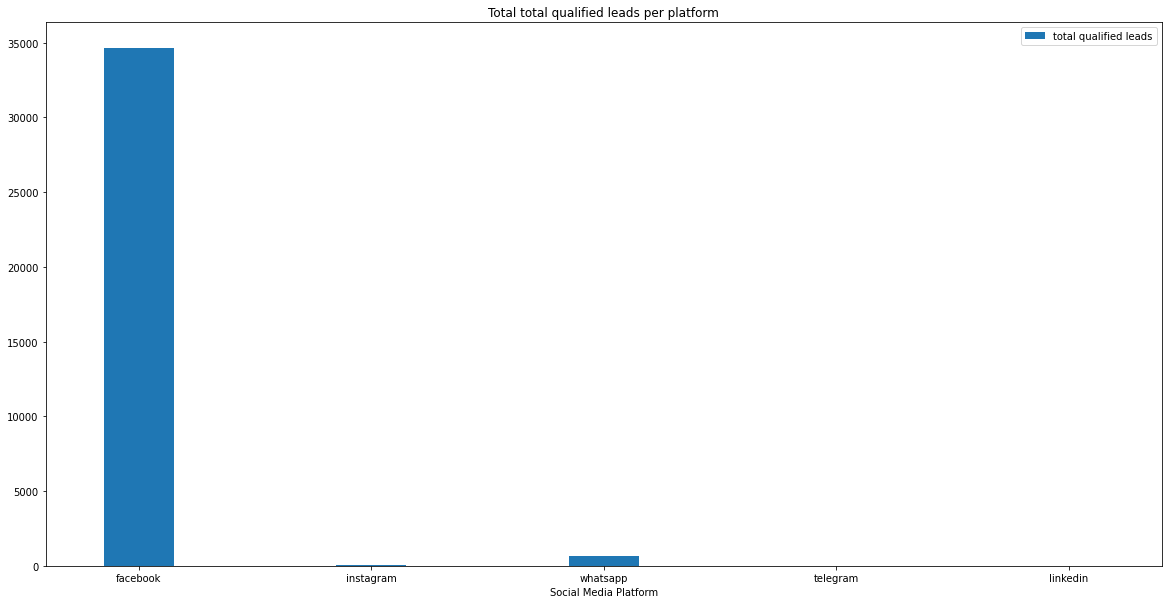

In [25]:
social_media_plot_abs = social_media_analysis_abs.plot(x='platform', y=['total qualified leads'], kind='bar', rot=0, figsize=(20,10), width=0.3)
social_media_plot_abs.set_xlabel('Social Media Platform')
social_media_plot_abs.set_title('Total total qualified leads per platform')
social_media_plot_abs.get_figure().savefig(f'figures/social_media_comparison_absolute.jpg')

### Observations from the above 2 graphs:
### Although the 1st graph may show that all platforms generate qualified leads within the same range, the 2nd graphs which visualizes the absolute count of qualified leads shows that facebook actually produces the majority of leads.

### Group various "call" sources into one value if they are in the same range

In [26]:
call_sources = [source for source in df['lead_source'].unique() if 'call' in source or 'sms' in source or 'phone' in source or 'hotline' in source]
call_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', call_sources)
call_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,phone,2054,2361,0.869970
1,sms,243,305,0.796721
2,hotline,815,1058,0.770321
3,call center resale,23,23,1.000000
4,callcenter,2,3,0.666667
5,cold call,26,26,1.000000
6,call,1,1,1.000000


In [27]:
# Sinc eall calls channnels are in the same range, group them under one value "call"
df.loc[df['lead_source'].isin(call_sources), 'lead_source'] = 'call'

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

### Group various "search engines" sources into one value if they are in the same range

In [28]:
search_engines = ['google', 'yahoo', 'ecosia',  'bing', 'duckduckgo']
search_engine_sources = [source for source in df['lead_source'].unique() if any(x in source for x in search_engines)]
search_engine_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', search_engine_sources)
search_engine_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,google,12713,15266,0.832766
1,r.search.yahoo.com,16,18,0.888889
2,google/landing page,747,918,0.813725
3,ecosia.org,2,2,1.000000
4,search.yahoo.com,7,9,0.777778
5,google-landing pages,20,31,0.645161
6,com.google.android.gm,0,1,0.000000
7,us.search.yahoo.com,2,2,1.000000
8,bing.com,24,27,0.888889
9,com.google.android.googlequicksearchbox,5,5,1.000000


In [29]:
for search_engine in search_engines:
    df.loc[df['lead_source'].str.contains(search_engine), 'lead_source'] = search_engine

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

search_engines = ['google', 'yahoo', 'ecosia',  'bing']
search_engine_sources = [source for source in df['lead_source'].unique() if any(x in source for x in search_engines)]
search_engine_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', search_engine_sources)
search_engine_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,google,13486,16222,0.831340
1,yahoo,28,32,0.875000
2,ecosia,2,2,1.000000
3,bing,24,27,0.888889


### Group various "forms" sources into one value if they are in the same range

In [30]:
forms_sources = [source for source in df['lead_source'].unique() if 'form' in source]
forms_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', forms_sources)
forms_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,organic form,399,442,0.902715
1,organic form direct,8,10,0.800000
2,top component form,31,41,0.756098
3,resale form,1,2,0.500000
4,custom form,3,3,1.000000
5,form src=newsletter,0,0,0.000000
6,form,5,9,0.555556
7,sahel_map_form,1,1,1.000000
8,type form,8,17,0.470588


In [31]:
df.loc[df['lead_source'].isin(['resale form', 'custom form', 'form src=newsletter', 'sahel_map_form', 'type form']), 'lead_source'] = 'form'
# fix typo
df.loc[df['lead_source'] == 'top component form', 'lead_source'] = 'top compound form'

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

forms_sources = [source for source in df['lead_source'].unique() if 'form' in source]
forms_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', forms_sources)
forms_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,organic form,399,442,0.902715
1,organic form direct,8,10,0.800000
2,top compound form,31,41,0.756098
3,form,18,32,0.562500


### Group various "websites" sources into one value if they generate high quality leads within the same range

In [32]:
websites_identifiers = ['com', 'net', 'org', 'io']
websites_identifiers_all = []
for identifier in websites_identifiers:
    # websites_identifiers_all.append(identifier)
    websites_identifiers_all.append('.'+identifier)
    websites_identifiers_all.append(identifier+'.')

websites_sources = [source for source in df['lead_source'].unique() if any(x in source for x in websites_identifiers_all)]
websites_sources.extend(['propertyfinder', 'criteo', 'newsletter', 'blog'])
websites_analysis_df = data_processor.get_column_analysis(unique_df, 'lead_source', websites_sources)
websites_analysis_df

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,m.nearbyme.io,1,1,1.000000
1,egyptianstreets.com,6,7,0.857143
2,www-cooingestate-com.cdn.ampproject.org,1,1,1.000000
3,int.search.myway.com,1,1,1.000000
4,smbsalesimplementation.my.salesforce.com,0,1,0.000000
5,newchat.ktree.org,0,4,0.000000
6,residencestyle.com,1,1,1.000000
7,blogwritr.com,0,0,0.000000
8,app.neilpatel.com,1,1,1.000000
9,m.akhbarelyom.com,0,0,0.000000


#### Not all websites generate leads within the same range, we need to detect low profile websites and group them together

In [33]:
low_quality_websites = []
for idx, row in websites_analysis_df.iterrows():
    if row['total leads generated'] < 5 or row['qualified_leads_ratio_per_column_value'] < 0.70:
        low_quality_websites.append(row['column unique values'])

df.loc[df['lead_source'].isin(low_quality_websites), 'lead_source'] = 'miscellaneous'

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

#### Review all sources stats after the data wrangling we just did

In [34]:
all_sources_analysis = get_column_participation_in_high_quality(unique_df, 'lead_source', df['lead_source'].unique())
all_sources_analysis

,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,google,13486,16222,0.831340
1,facebook,34622,41114,0.842098
2,app,643,757,0.849406
3,organic search,1165,1295,0.899614
4,landing page,769,870,0.883908
5,website,2995,3452,0.867613
6,call,3164,3777,0.837702
7,whatsapp,669,706,0.947592
8,propertyfinder,110,140,0.785714
9,yahoo,28,32,0.875000


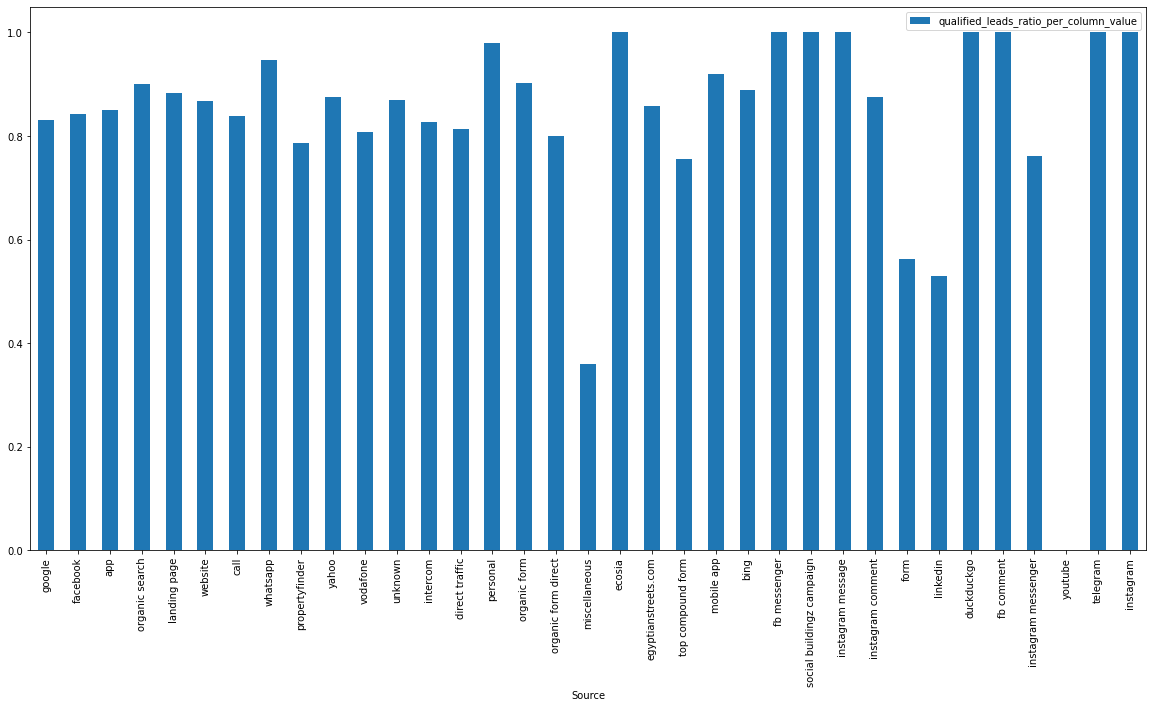

In [35]:
ax = all_sources_analysis.plot(x='column unique values', y=['qualified_leads_ratio_per_column_value'], kind='bar', figsize=(20,10))
ax.set_xlabel('Source')
ax.get_figure().savefig(f'figures/sources_high_leads_ratios_comparison.jpg')

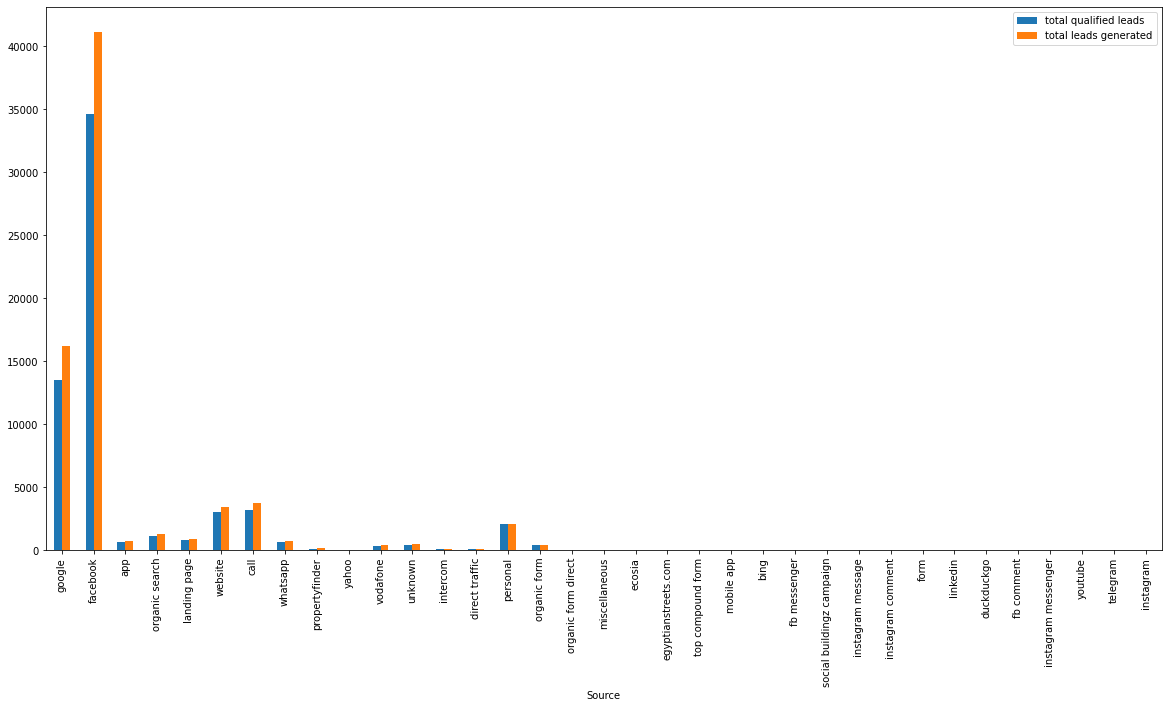

In [36]:
ax = all_sources_analysis.plot(x='column unique values', y=['total qualified leads', 'total leads generated'], kind='bar', figsize=(20,10))
ax.set_xlabel('Source')
ax.get_figure().savefig(f'figures/sources_high_leads_absolute_total_leads_absolute.jpg')

### Observations from the above 2 graphs:
### Although the 1st graph may show that all source are within the same range, the 2nd graphs which visualizes the absolute count of high leads and absolute count of total leads shows that only few channels really make a difference while almost more than half of the sources are useless.

### 4. Method of Contact

In [37]:
print_column_value_counts(unique_df, 'method_of_contact')

facebook - 38977
generic form - 8407
phone - 6211
whatsapp - 6177
top compounds form - 5063
organic form - 1737
personal - 1642
form adwords - 668
website - 462
vodafone - 436
facebook comment - 381
app - 329
google - 326
client referral - 192
facebook messenger - 191
organic form direct - 127
l.facebook.com - 96
intercom - 92
personal/rafea - 81
facebook message - 73
facebook page referral - 72
management referral - 64
generic contact us - 61
personal/ghanima - 42
top component form - 41
bing.com - 27
cold call - 26
call center resale - 23
instagram messenger - 21
r.search.yahoo.com - 18
type form - 17
referral - 15
linkedin - 14
instagram page referral - 10
form - 9
propertyfinder - 9
search.yahoo.com - 9
instagram comment - 8
managment referral - 7
egyptianstreets.com - 7
form facebook - 7
fb messenger - 7
personal aly - 6
com.google.android.googlequicksearchbox - 5
lm.facebook.com - 4
instagram message - 4
newchat.ktree.org - 4
whastapp - 3
custom form - 3
callcenter - 3
resale for

#### Exactly the same logic we did with leads_source column since both column almost have the same values and distribution

In [38]:
ambigious = ['Unknown', 'None', 'Localhost', 'Test', 'Unkown']
ambigious_combinations = []
for word in ambigious:
    ambigious_combinations.append(word)
    ambigious_combinations.append(f'({word})')
    ambigious_combinations.append(word.lower())
    ambigious_combinations.append(f'({word.lower()})')

col_name = 'method_of_contact'

df.loc[(df[col_name].str.contains('what')) | (df[col_name].str.contains('whast')), col_name] = 'whatsapp'
df.loc[df[col_name] == 'youtube.com', col_name] = 'youtube'
df.loc[df[col_name].str.contains('linkedin'), col_name] = 'linkedin'
df.loc[df[col_name].str.contains('telegram'), col_name] = 'telegram'
df.loc[df[col_name].str.contains('|'.join(ambigious_combinations)), col_name] = 'unknown'

personal_methods = [method for method in df[col_name].unique()  if ('personal' in method or 'referral' in method or 'client' in method)]# and 'instagram' not in method and 'page' not in method]
df.loc[df[col_name].isin(personal_methods), col_name] = 'personal'

# instagram_methods = [method for method in df[col_name].unique() if 'instagram' in method]
exceptions = ['fb', 'comment', 'message', 'message']
facebook_methods = [method for method in df[col_name].unique() if 'facebook' in method and not any(x in method for x in exceptions)]
df.loc[df[col_name].isin(facebook_methods), col_name] = 'facebook'
# whatsapp_methods = [method for method in df[col_name].unique() if 'whatsapp' in method]
# linkedin_methods = [method for method in df[col_name].unique() if 'linkedin' in method]
# telegram_methods = [method for method in df[col_name].unique() if 'telegram' in method]

call_methods = [method for method in df[col_name].unique() if 'call' in method or 'sms' in method or 'phone' in method or 'hotline' in method]
df.loc[df[col_name].isin(call_methods), col_name] = 'call'

forms_methods = [method for method in df[col_name].unique() if 'form' in method]
df.loc[df[col_name].isin(['resale form', 'custom form', 'form src=newsletter', 'sahel_map_form', 'type form']), col_name] = 'form'

search_engines = ['google', 'yahoo', 'ecosia',  'bing', 'duckduckgo']
for search_engine in search_engines:
    df.loc[df[col_name].str.contains(search_engine), col_name] = search_engine


websites_identifiers = ['com', 'net', 'org', 'io']
websites_identifiers_all = []
for identifier in websites_identifiers:
    # websites_identifiers_all.append(identifier)
    websites_identifiers_all.append('.'+identifier)
    websites_identifiers_all.append(identifier+'.')

websites_methods = [method for method in df[col_name].unique() if any(x in method for x in websites_identifiers_all)]
websites_methods.extend(['propertyfinder', 'criteo', 'newsletter', 'blog', 'social buildingz campaign'])

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

websites_analysis_df = data_processor.get_column_analysis(unique_df, col_name, websites_methods)

low_quality_websites = []
for idx, row in websites_analysis_df.iterrows():
    if row['total leads generated'] < 5 or row['qualified_leads_ratio_per_column_value'] < 0.70:
        low_quality_websites.append(row['column unique values'])

df.loc[df[col_name].isin(low_quality_websites), col_name] = 'miscellaneous'

data_processor.update_df(df)
unique_df = data_processor.get_unique_df()

method_of_contact_analysis_df = data_processor.get_column_analysis(unique_df, col_name, unique_df[col_name].unique())
method_of_contact_analysis_df

C:\Users\Orignal\AppData\Local\Temp/ipykernel_15968/3949674545.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df[col_name].str.contains('|'.join(ambigious_combinations)), col_name] = 'unknown'


,column unique values,total qualified leads,total leads generated,qualified_leads_ratio_per_column_value
0,generic form,6888,8407,0.819317
1,facebook,33164,39275,0.844405
2,top compounds form,4374,5063,0.863915
3,whatsapp,5414,6182,0.875768
4,organic form,1564,1737,0.900403
5,form adwords,534,668,0.799401
6,call,5137,6264,0.820083
7,website,413,462,0.893939
8,yahoo,28,32,0.875000
9,vodafone,352,436,0.807339


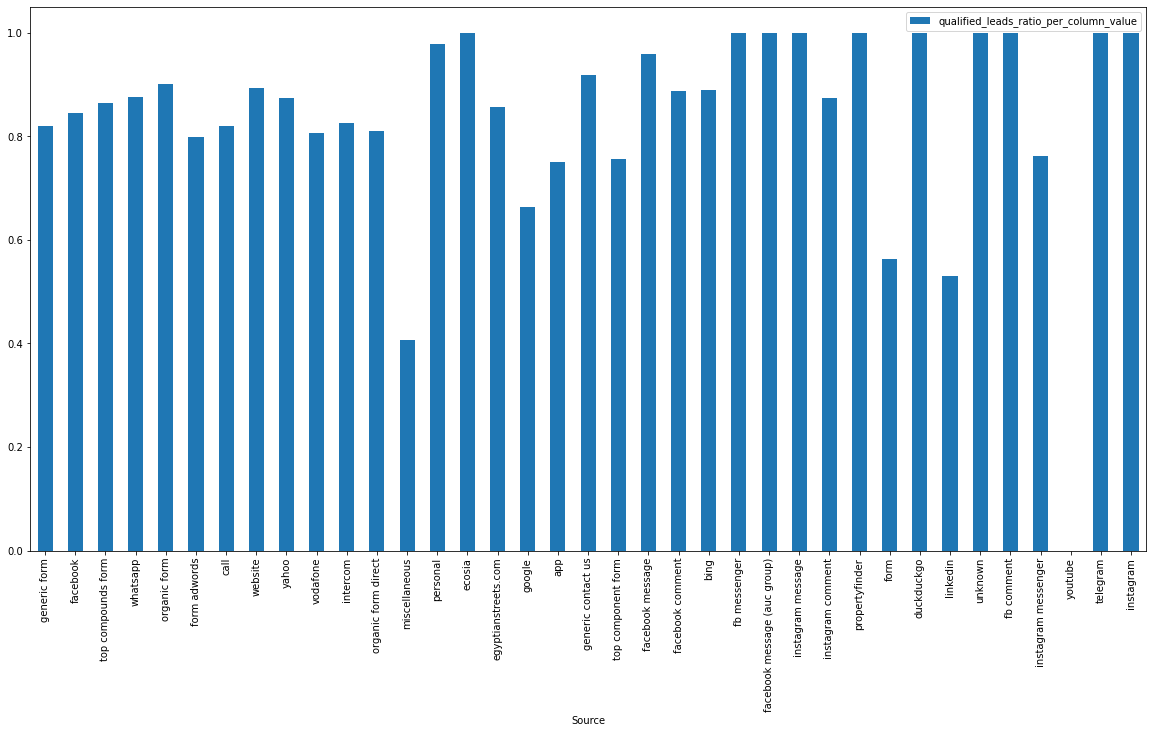

In [39]:
ax = method_of_contact_analysis_df.plot(x='column unique values', y=['qualified_leads_ratio_per_column_value'], kind='bar', figsize=(20,10))
ax.set_xlabel('Source')
ax.get_figure().savefig(f'figures/contact_methods_high_leads_ratios_comparison.jpg')

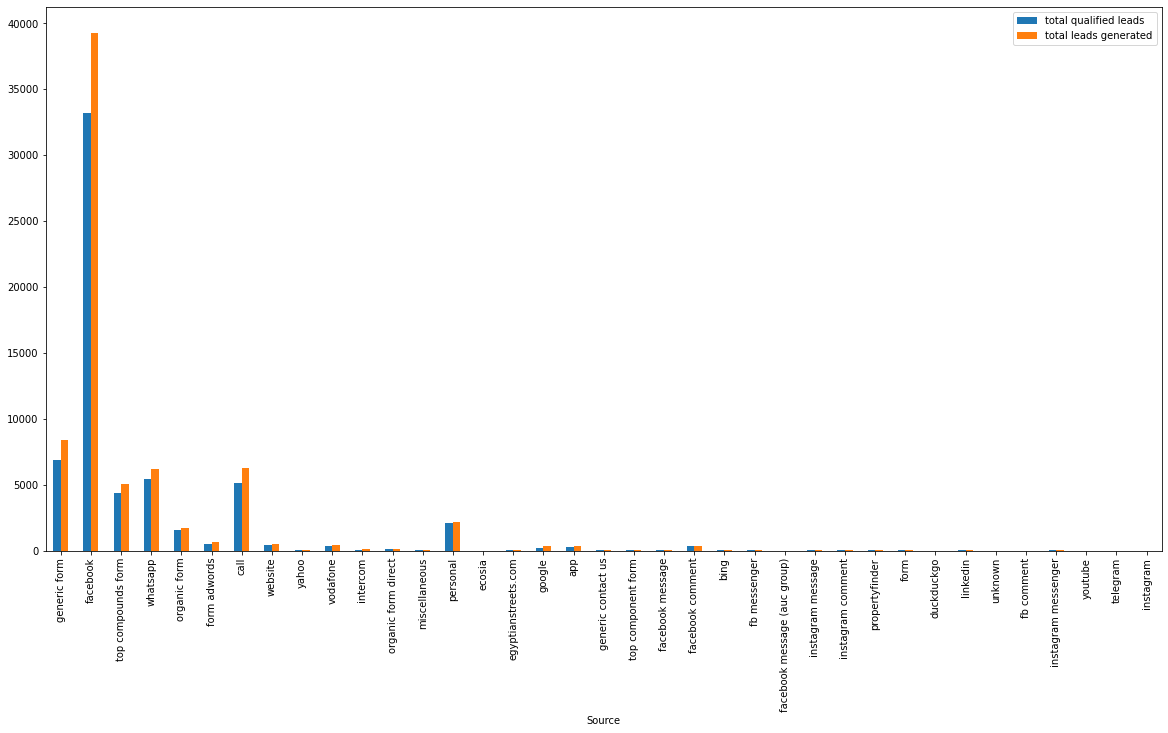

In [40]:
ax = method_of_contact_analysis_df.plot(x='column unique values', y=['total qualified leads', 'total leads generated'], kind='bar', figsize=(20,10))
ax.set_xlabel('Source')
ax.get_figure().savefig(f'figures/contact_methods_high_leads_absolute_total_leads_absolute.jpg')

### Same observations as lead_sources column

## Model

In [41]:
df.head()

,lead_id,customer_name,lead_mobile_network,message,lead_time,month,year,method_of_contact,ad_group,lead_source,campaign,location,low_qualified
0,22,Rajaa M.Mousa,Orange,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:21,3,2022,generic form,none,google,dev_-_sodic,sodic october plaza,0
1,30,Sahar Shalaby,Vodafone,ad_id : 23843176891470664 \nform_id : 36774549...,2019-09-16 13:17:18,9,2019,facebook,o west - fb_creme de la creme_ cairo/giza_27-60,facebook,orascom - lead generation,o west,0
2,42,Mohamed,Vodafone,message:,2022-05-07 02:03:54,5,2022,generic form,gouna_-_properties,google,locations,el gouna for sale & resale,0
3,44,Maher Elnakib,Orange,ad_id : 23844249544660664 \nadset_id : 2384424...,2019-12-19 22:56:47,12,2019,facebook,new release north edge general with north coas...,facebook,city edge - lead generation,north edge,0
4,48,pierre,Vodafone,message:,2022-01-27 05:56:23,1,2022,top compounds form,none,google,dev_-_inertia_egypt,joulz,0


In [42]:
from core_modules.classifier import Classifier

In [43]:
classifier = Classifier()
x_cols, clf = classifier.train_classifer(df)

Recall score: 0.07626310772163966
Saved classifier


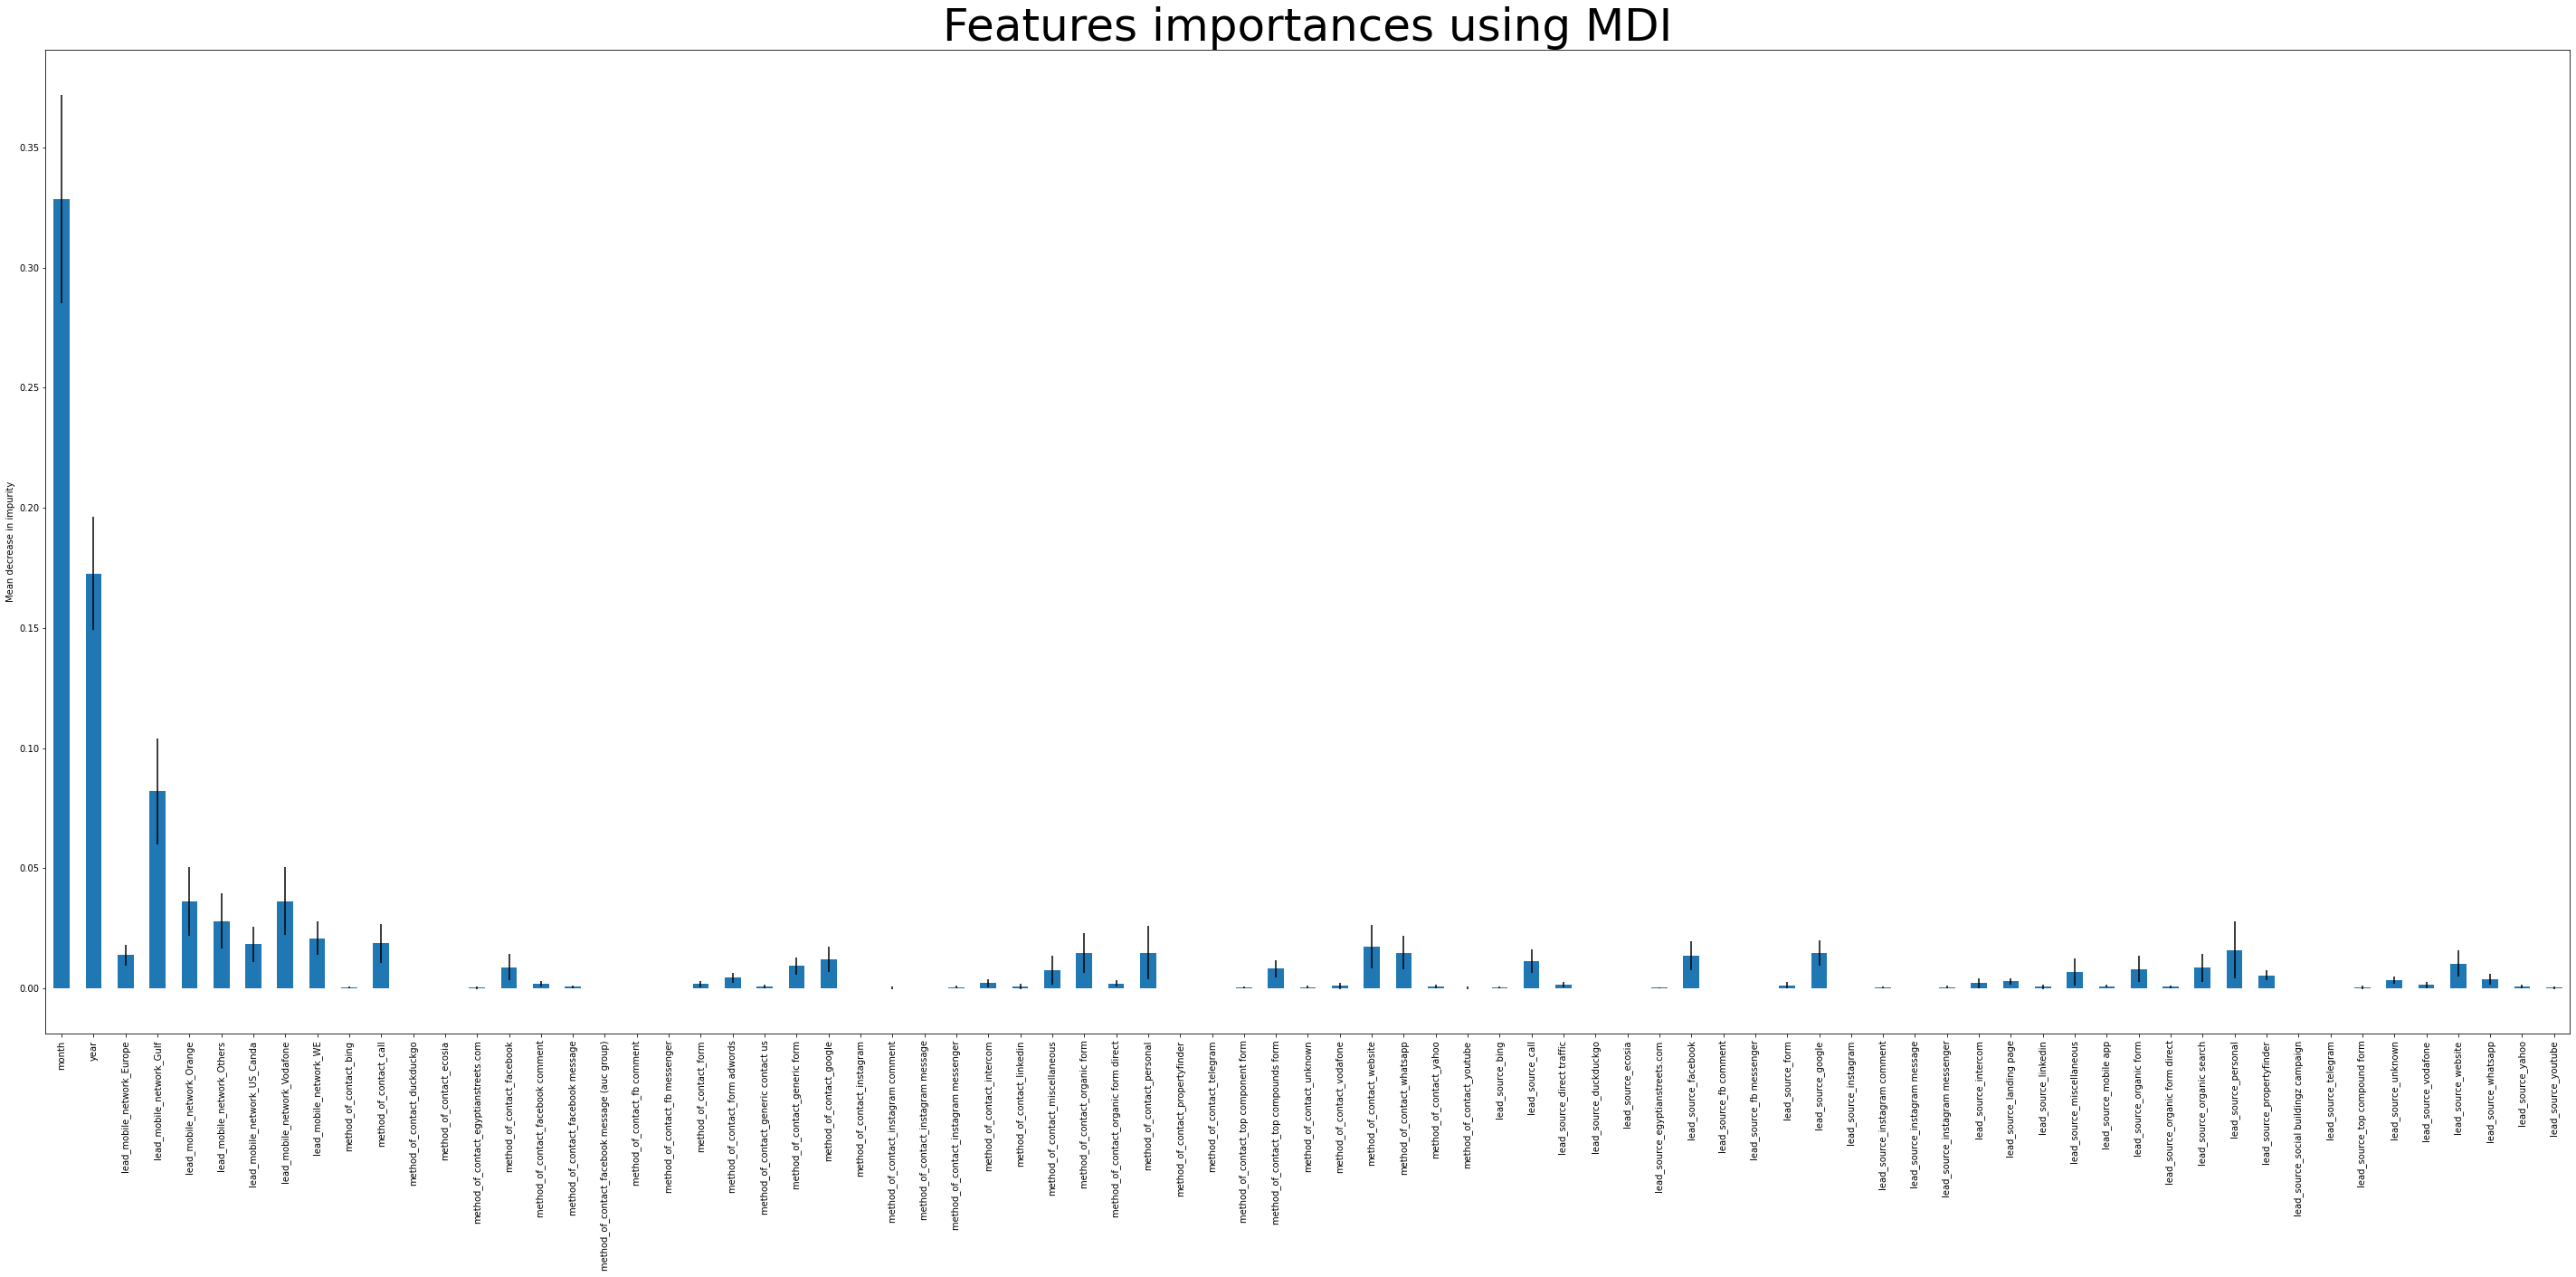

In [45]:
import time
import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=x_cols)

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(50)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Features importances using MDI", fontsize=50)
ax.set_ylabel("Mean decrease in impurity")
fig.get_figure().savefig('figures/features importances.jpg')